<a href="https://colab.research.google.com/github/ITAM-DS/deep-learning/blob/ag%2Fclasificacion/02_clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase.

Trabajaremos con un conjunto de datos _estandar_ para probar algoritmos de clasificación. 
El conjunto de datos es _parecido_ al conjunto de clasificacion de dígitos MNIST aunque posee un complejidad mayor [[Xiao et al., 2018]](https://arxiv.org/abs/1708.07747). 

El ejemplo está basado en la publicación multimedia [[Zhang et al., 2020]](https://d2l.ai/d2l-en.pdf). Por simplicidad, nos centraremos en la versión del código basado en `Tensorflow` y `Keras`. 



In [1]:
# !pip install -U d2l
from d2l import tensorflow as d2l
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Podemos decargar el conjunto de datos con las herramientas que incluye el módulo. 

In [2]:
mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()

Las imágenes son de $28 \times 28$ pixeles y representan 10 categorías. Las clases están balanceadas y en total hay 60K observaciones en el conjunto de entrenamiento y 10K en el de prueba. 

In [3]:
len(mnist_train[0]), len(mnist_test[0])

(60000, 10000)

La función de abajo convierte las etiquetas (numéricas) en etiquetas legibles.

In [4]:
def get_fashion_mnist_labels(labels):  
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

También podemos incluir una función que imprima las imagénes. 

In [5]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy(), cmap = 'gray')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    
    return axes

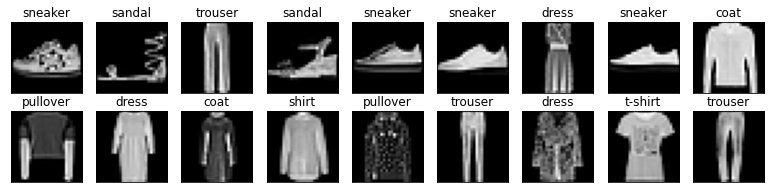

In [6]:
index = np.random.randint(60000, size = 18)

X = tf.constant(mnist_train[0][index])
y = tf.constant(mnist_train[1][index])
show_images(X, 2, 9, titles=get_fashion_mnist_labels(y));

## Carga de datos completa

La función de abajo carga el conjunto de datos y se encarga de estandarizar y construir los iteradores para el entrenamiento por bloques. 

In [7]:
def load_data_fashion_mnist(batch_size, resize=None):   
    """Download the Fashion-MNIST dataset and then load it into memory."""
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # Divide all numbers by 255 so that all pixel values are between
    # 0 and 1, add a batch dimension at the last. And cast label to int32
    
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    
    resize_fn = lambda X, y: (
        tf.image.resize_with_pad(X, resize, resize) if resize else X, y)
    
    return (
        tf.data.Dataset.from_tensor_slices(process(*mnist_train)).batch(
            batch_size).shuffle(len(mnist_train[0])).map(resize_fn),
        
        tf.data.Dataset.from_tensor_slices(process(*mnist_test)).batch(
            batch_size).map(resize_fn)
    )

In [8]:
batch_size = 250
train_iter, test_iter = load_data_fashion_mnist(batch_size)

Los datos estructurados de la siguiente forma. ¿Por qué son tensores de 4D?

In [9]:
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

(250, 28, 28, 1) <dtype: 'float32'> (250,) <dtype: 'int32'>


### Ejercicios

#### 1. Reducir el tamaño del bloque afecta la implementación de la carga y manipulación

- Lo único que hay que hacer es cambiar el parámetro *batch_size*.

#### 2. ¿Se te ocurre otra manera de modificar el iterador para construir uno mas eficiente?

- Tal vez se podrían guardar las imágenes como una *sparse matrix*.

#### 3. ¿Qué otros conjuntos de datos están disponibles a traves de Keras?

- Varios datasets están disponibles en el módulo [*tf.keras.datasets*](https://keras.io/api/datasets/)

## El modelo de clasificación 

Ahora si, constuiremos el modelo de clasificación desde zero para entender todo el procedimiento. Primero que nada, exploraremos cómo definir la función `softmax`. Para esto veamos como funciona el operador `reduce_sum`. 

In [10]:
X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])

print("Tensor original: ")
print(X.numpy())

print("\nSumando renglones: ")
print(tf.reduce_sum(X, 0, keepdims=True).numpy())

print("\nSumando columnas: ")
print(tf.reduce_sum(X, 1, keepdims=True).numpy())

print("\nSumando columnas (sin parámetro *keepdims*): ")
print(tf.reduce_sum(X, 1, keepdims=False).numpy())

Tensor original: 
[[1. 2. 3.]
 [4. 5. 6.]]

Sumando renglones: 
[[5. 7. 9.]]

Sumando columnas: 
[[ 6.]
 [15.]]

Sumando columnas (sin parámetro *keepdims*): 
[ 6. 15.]


In [11]:
def softmax(X):
    X_exp = tf.exp(X)
    print(X_exp)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    print(partition)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [12]:
X = tf.random.normal((2, 5), 0, 1)
X_prob = softmax(X)

print("\nTensor original: ")
print(X.numpy())

print("\nTensor de probabilidades: ")
print(X_prob.numpy()) 

print("\nVerificando probabilidades")
print(tf.reduce_sum(X_prob, 1, keepdims = True).numpy())

tf.Tensor(
[[1.4896108  0.6127033  4.373779   6.8969836  2.677876  ]
 [0.7197987  2.451931   1.1759454  0.67969054 1.8529266 ]], shape=(2, 5), dtype=float32)
tf.Tensor(
[[16.050953]
 [ 6.880292]], shape=(2, 1), dtype=float32)

Tensor original: 
[[ 0.3985149  -0.48987448  1.4756273   1.9310842   0.985024  ]
 [-0.32878372  0.8968759   0.1620724  -0.3861177   0.61676633]]

Tensor de probabilidades: 
[[0.09280513 0.03817239 0.2724934  0.4296931  0.16683595]
 [0.10461746 0.3563702  0.17091504 0.09878804 0.2693093 ]]

Verificando probabilidades
[[1.]
 [1.]]


### Definir los parámetros del modelo. 

In [13]:
num_inputs = 784
num_outputs = 10

W = tf.Variable(tf.random.normal(shape=(num_inputs, num_outputs),
                                 mean=0, stddev=0.01))
b = tf.Variable(tf.zeros(num_outputs))

### Definimos el modelo

In [14]:
def net(X):
    return softmax(tf.matmul(tf.reshape(X, (-1, W.shape[0])), W) + b)

### Definimos la función de pérdida

Supongamos que tenemos dos observaciones, y es un problema de clasificacion con tres etiquetas (por ejemplo: `perro`, `gato`, `pollo`). Tenemos las salidas de un modelo de clasificacion en `y_hat` y la clase a la que pertenece cada uno en `y` (recuerda que `python` empieza desde 0). 

In [15]:
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = tf.constant([0, 2])


print("Probabilidades: \n%s"%y_hat.numpy())

print("\nEtiquetas: \n%s"%y.numpy())

print("\nCodificacion: \n%s"%tf.one_hot(y, depth=y_hat.shape[-1]).numpy())

print("\nMascara: \n%s"%tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1])).numpy())

Probabilidades: 
[[0.1 0.3 0.6]
 [0.3 0.2 0.5]]

Etiquetas: 
[0 2]

Codificacion: 
[[1. 0. 0.]
 [0. 0. 1.]]

Mascara: 
[0.1 0.5]


La máscara nos permite reducir la suma para aquellas etiquetas igual a uno. 

In [16]:
def cross_entropy(y_hat, y):
    return -tf.math.log(tf.boolean_mask(
        y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))
                       )

cross_entropy(y_hat, y)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.3025851, 0.6931472], dtype=float32)>

### Calculamos la precision de las etiquetas 

In [17]:
def accuracy(y_hat, y): 
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = tf.argmax(y_hat, axis=1)
    cmp = tf.cast(y_hat, y.dtype) == y
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))

In [18]:
accuracy(y_hat, y) / len(y)

0.5

Podemos calcular la precision para un conjunto partido en bloques aprovechando el iterador que ya tenemos. 
En este caso nos apoyamos de una clase `Accumulator` que nos permitirá llevar un conteo de 

In [19]:
def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), tf.size(y).numpy())
    return metric[0] / metric[1]

In [20]:
class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [21]:
evaluate_accuracy(net, test_iter)

tf.Tensor(
[[1.0364006  1.0188756  0.91667575 ... 0.95766735 1.0346369  1.0063667 ]
 [0.9942771  1.2179908  1.0047058  ... 1.2692579  1.2506378  1.0314448 ]
 [0.966692   0.955303   1.1020528  ... 0.9770521  1.2595952  0.91362095]
 ...
 [1.0052509  1.0279061  0.8099351  ... 1.1240573  1.2422403  1.0784111 ]
 [1.0448301  1.0715059  0.9176951  ... 1.0518012  1.2149084  1.0360534 ]
 [1.0001814  1.1171062  0.88048065 ... 1.1132339  1.4264797  0.9614966 ]], shape=(250, 10), dtype=float32)
tf.Tensor(
[[ 9.769602 ]
 [10.324272 ]
 [ 9.662203 ]
 [ 9.908291 ]
 [10.158949 ]
 [ 9.937605 ]
 [10.4062805]
 [ 9.996205 ]
 [ 9.915651 ]
 [ 9.908259 ]
 [ 9.720785 ]
 [ 9.763192 ]
 [ 9.737345 ]
 [ 9.552902 ]
 [10.059534 ]
 [ 9.734118 ]
 [10.062753 ]
 [10.050644 ]
 [ 9.391308 ]
 [10.042692 ]
 [ 9.678039 ]
 [ 9.835522 ]
 [ 9.712483 ]
 [ 9.6480875]
 [ 9.903418 ]
 [10.060703 ]
 [10.023249 ]
 [ 9.901201 ]
 [ 9.663658 ]
 [ 9.885452 ]
 [ 9.813132 ]
 [10.426976 ]
 [ 9.727867 ]
 [ 9.887828 ]
 [10.433462 ]
 [ 9.973776

 [10.177335 ]], shape=(250, 1), dtype=float32)
tf.Tensor(
[[0.93019766 0.9621244  1.1289526  ... 0.99350446 1.157043   0.9742417 ]
 [1.0010023  1.0890961  0.899758   ... 1.0933666  1.1091877  1.0393252 ]
 [1.0432557  1.1355647  1.0645785  ... 1.0913435  1.2787707  0.9586879 ]
 ...
 [0.97905964 0.9751375  1.2961477  ... 1.0367466  1.3378904  0.9555095 ]
 [1.0599523  1.0447263  0.9317598  ... 0.9898688  1.0374578  0.9593436 ]
 [1.0028304  1.0025059  1.0266223  ... 0.9718911  1.0490043  0.92665553]], shape=(250, 10), dtype=float32)
tf.Tensor(
[[ 9.821911 ]
 [ 9.9934025]
 [ 9.99312  ]
 [ 9.489944 ]
 [ 9.859586 ]
 [ 9.712841 ]
 [ 9.798643 ]
 [ 9.582016 ]
 [ 9.947182 ]
 [ 9.60308  ]
 [ 9.522496 ]
 [ 9.02558  ]
 [ 9.773445 ]
 [ 9.965063 ]
 [ 9.850028 ]
 [ 9.403326 ]
 [ 9.689056 ]
 [10.216582 ]
 [10.060797 ]
 [10.0172615]
 [ 9.7048435]
 [ 9.7423   ]
 [ 9.501931 ]
 [ 9.556305 ]
 [ 9.757607 ]
 [ 9.873547 ]
 [ 9.997079 ]
 [10.423765 ]
 [10.026573 ]
 [10.148885 ]
 [ 9.91811  ]
 [10.066696 ]
 [10.1

 [10.163026 ]], shape=(250, 1), dtype=float32)
tf.Tensor(
[[1.0043774  0.9997117  0.9867981  ... 1.053936   1.1390059  1.0135224 ]
 [1.0351558  1.026108   1.0064105  ... 1.0042475  1.0616354  1.1102277 ]
 [1.014466   1.1307304  0.9422519  ... 1.1211538  1.3158754  1.0327072 ]
 ...
 [0.98921716 0.98720366 0.9147377  ... 0.9307571  1.03977    1.0155145 ]
 [0.9102766  0.9753675  1.047882   ... 0.9743787  1.1831961  0.93920344]
 [0.95951086 1.096769   1.0084609  ... 0.94988465 1.2264556  1.0176274 ]], shape=(250, 10), dtype=float32)
tf.Tensor(
[[ 9.882656 ]
 [ 9.920092 ]
 [10.149843 ]
 [10.015872 ]
 [10.023837 ]
 [ 9.989688 ]
 [ 9.630212 ]
 [ 9.865345 ]
 [ 9.9562   ]
 [ 9.6544695]
 [10.088341 ]
 [ 9.313057 ]
 [ 9.738651 ]
 [ 9.832367 ]
 [ 9.839313 ]
 [10.099809 ]
 [ 9.568964 ]
 [10.125576 ]
 [ 9.839687 ]
 [ 9.771244 ]
 [ 9.206617 ]
 [10.012785 ]
 [10.062993 ]
 [ 9.299586 ]
 [ 9.63694  ]
 [ 9.938122 ]
 [ 9.616041 ]
 [10.29455  ]
 [ 9.903484 ]
 [ 9.63192  ]
 [ 9.937033 ]
 [ 9.7960005]
 [10.0

 [ 9.926456 ]], shape=(250, 1), dtype=float32)
tf.Tensor(
[[1.049467   0.99378836 0.92617536 ... 0.89884573 1.092251   0.95439684]
 [1.0878906  1.1060916  1.0045092  ... 1.1513462  1.2276621  0.997819  ]
 [0.9038556  1.1357918  0.962652   ... 1.2085974  1.2184697  1.0138372 ]
 ...
 [1.0576406  1.019741   1.0347468  ... 0.89571166 1.0740125  0.9390278 ]
 [1.0235589  0.9592695  1.124442   ... 0.99269265 1.2463764  0.9967997 ]
 [1.0546345  1.0118221  1.2614005  ... 1.0638466  1.2469444  0.9817583 ]], shape=(250, 10), dtype=float32)
tf.Tensor(
[[ 9.540573 ]
 [ 9.906221 ]
 [10.467714 ]
 [ 9.650396 ]
 [10.406168 ]
 [10.321192 ]
 [ 9.876175 ]
 [ 9.417063 ]
 [ 9.924777 ]
 [10.049421 ]
 [ 9.648987 ]
 [ 9.516986 ]
 [10.091831 ]
 [ 9.53705  ]
 [ 9.782106 ]
 [ 9.787176 ]
 [10.06435  ]
 [10.270291 ]
 [10.1023655]
 [ 9.924877 ]
 [ 9.658906 ]
 [ 9.711128 ]
 [ 9.024637 ]
 [ 9.813588 ]
 [10.239607 ]
 [10.168579 ]
 [ 9.482561 ]
 [10.02291  ]
 [10.342184 ]
 [ 9.353405 ]
 [ 9.765482 ]
 [ 9.572674 ]
 [ 9.6

tf.Tensor(
[[1.094378   1.0637742  0.8857894  ... 0.8813804  1.2265553  1.0498925 ]
 [1.0638734  0.93193114 1.0291972  ... 0.966012   1.2467902  0.8603249 ]
 [1.0406177  0.99040157 1.1433518  ... 1.1222067  1.3009807  0.9302269 ]
 ...
 [0.93354213 0.9553482  0.97238976 ... 0.9308099  1.1329759  0.980744  ]
 [1.089947   1.0163482  1.0111091  ... 1.0503938  1.080494   0.90372294]
 [0.983559   1.141585   0.8854682  ... 1.2085427  1.1793995  1.0605342 ]], shape=(250, 10), dtype=float32)
tf.Tensor(
[[10.039853 ]
 [ 9.77378  ]
 [10.205381 ]
 [10.00541  ]
 [ 9.792029 ]
 [10.111765 ]
 [ 9.19149  ]
 [ 9.947082 ]
 [ 9.963533 ]
 [10.139    ]
 [ 9.662652 ]
 [ 9.716729 ]
 [ 9.916485 ]
 [10.125904 ]
 [ 9.522461 ]
 [ 9.919827 ]
 [ 9.147986 ]
 [10.261892 ]
 [ 9.967596 ]
 [10.157989 ]
 [ 9.746332 ]
 [ 9.561726 ]
 [ 9.480535 ]
 [ 9.72031  ]
 [ 9.721303 ]
 [ 9.987709 ]
 [ 9.24433  ]
 [10.187436 ]
 [ 9.495066 ]
 [10.272503 ]
 [10.093643 ]
 [10.119817 ]
 [ 9.783205 ]
 [ 9.399448 ]
 [ 9.612801 ]
 [ 9.870482

0.0868

In [22]:
def train_epoch_procedure(net, train_iter, loss, updater):  #@save
    """The training loop."""
    # Keep record of 3 metrics: 
    #     1) training loss, 
    #     2) training accuracy, 
    #     3) no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        with tf.GradientTape() as tape:
            y_hat = net(X)
            # Keras implementations for loss takes (labels, predictions)
            # instead of (predictions, labels) that users might implement
            # in this book, e.g. `cross_entropy` that we implemented above
            if isinstance(loss, tf.keras.losses.Loss):
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        # Keras loss by default returns the average loss in a batch
        l_sum = l * float(tf.size(y)) if isinstance(
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

El siguiente codigo implementa una animación con la que podemos ver el avance del proceso de entrenamiento.

In [23]:
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [24]:
def train_procedure(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """Train a model."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'], 
                       figsize = [12, 4])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_procedure(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [25]:
class Updater():  #@save
    """For updating parameters using minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def __call__(self, batch_size, grads):
        d2l.sgd(self.params, grads, self.lr, batch_size)

updater = Updater([W, b], lr=0.1)

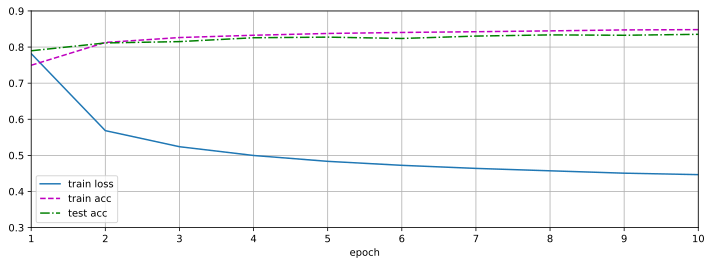

In [26]:
num_epochs = 10
train_procedure(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

tf.Tensor(
[[1.38612790e-02 9.90595855e-03 8.31327885e-02 ... 2.07001389e+02
  9.05700016e+00 6.95626709e+02]
 [9.20717525e+00 1.14672594e-01 1.73267344e+04 ... 4.90201637e-05
  1.20548773e+00 2.11653439e-03]
 [2.69806385e+01 2.79507094e+05 5.22748137e+00 ... 8.37428272e-02
  2.12688893e-01 3.10017820e-03]
 ...
 [6.60754442e-01 2.43884206e-01 1.38254639e+03 ... 2.68127071e-04
  1.77264519e+01 8.35177896e-04]
 [1.94443130e+00 1.71775684e-01 7.79390793e+01 ... 1.16803288e-03
  8.20606995e+00 1.85579732e-02]
 [2.79103100e-01 3.17936301e-01 1.32703760e+03 ... 3.80944584e-05
  2.54091682e+01 5.35210071e-04]], shape=(250, 10), dtype=float32)
tf.Tensor(
[[1.05132605e+03]
 [1.84800820e+04]
 [2.79575906e+05]
 [1.02455938e+05]
 [1.29884460e+02]
 [7.38425781e+03]
 [5.24420959e+02]
 [2.24389435e+02]
 [2.46084805e+01]
 [9.53302185e+02]
 [5.37943909e+02]
 [1.55517120e+02]
 [1.90764999e+02]
 [1.86803882e+03]
 [4.59510547e+03]
 [4.09918701e+03]
 [2.11984009e+02]
 [6.73491394e+02]
 [3.34643372e+02]
 [3

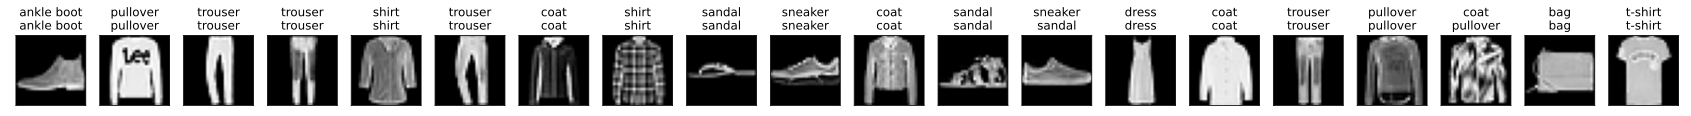

In [27]:
def predict_procedure(net, test_iter, n=6):  #@save
    """Predict labels."""
    for kk, (X, y) in enumerate(test_iter):
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(tf.argmax(net(X), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        tf.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])

predict_procedure(net, test_iter, n = 20)

### Ejercicios

#### 1. ¿Por qué se necesita la opción de `keep_dims` en el operador `reduce_sum`?

Porque, de lo contrario, la matriz convertitía sus renglones en columnas.

#### 2. Explora casos en los que el clasificador tuvo problemas para etiquetar.

- Dos etiquetas en las que el modelo tuvo problemas fueron:
    1. sneaker: se confundió con "sandal".
    
    2. coat: se confundió con "pullover".


- Claramente hay una gran similitud entre la clasificación y su error, de ahí la dificultad para encontrar la respuesta correcta.

#### 3. Implementamos la función softmax como esta expresada matematicamente. Cual sería el problema de utilizarla si una combinación lineal en una de las categorías es igual a 50 y el resto son números entre [-2,2].

#### 4. Es siempre buena idea reportar la etiqueta mas probable. ¿Que sucedería en un diagnóstico médico? 

- Podrías perder la oportunidad de ver otros diagnósticos relevantes.

#### 5. ¿Cual seria el problema de usar regresión _softmax_ para predecir la siguiente palabra cuando tenemos un vocabulario muy grande? 

- Qué muchas de las alternativas verían su probabilidad reducida casi a cero.

---
---